## Example

To do: 
- Further explanations
- References
- Size (in kms) of plotted maps

In [1]:
import numpy as np
import pandas as pd
import os
import json
path_data = 'data' + os.sep

### Import rupture information

For now we include the rupture info provided by the USGS shakemap system.
https://earthquake.usgs.gov/earthquakes/eventpage/us6000jllz/shakemap/metadata  
The `rupture.json` file was downloaded on 2023-14-02 at 14:55 CET. Check for new updates before applying.

We model the rupture as a collection of multiple planar rupture surfaces. This is done via the `get_planarsurface` method. For significant changes in the rupture information and geometry, one might has to adapt this method. 

In [2]:
from openquake.hazardlib.source.rupture import BaseRupture
from openquake.hazardlib.geo.point import Point
from utils import get_planarsurface

f = open(path_data + 'rupture.json')
rup_temp = json.load(f)
f.close()

print('Used rupture model:')
print(rup_temp['metadata']['reference'])

rupture_surface = get_planarsurface(rup_temp['features'][0]['geometry'])
rup_temp = rup_temp['metadata']
rupture = BaseRupture(mag = rup_temp['mag'], rake = rup_temp['rake'], 
                    tectonic_region_type = 'Active Shallow Crust', 
                    hypocenter = Point(longitude = rup_temp['lon'], 
                                        latitude = rup_temp['lat'],
                                        depth = rup_temp['depth']),
                    surface = rupture_surface)

Used rupture model:
Source: Wald Finite Fault Model (surface trace, FF model, known faults)Event ID: us6000jllzModel created: 2023-02-09 19:17 MST


### Import station list

For now we include the station list provided by the USGS shakemap system.
https://earthquake.usgs.gov/earthquakes/eventpage/us6000jllz/shakemap/metadata  
The `stationlist.json` file was downloaded on 2023-14-02 at 14:55 CET. Check for new updates before applying.

The method `read_stationlist` collects the longitude, latitude and vs30 values for each station, as well as the recorded amplitude values in two horizontal directions. Following amplitudes are available: 'PGA', 'PGV', 'SA(0.3)', 'SA(1.0)', 'SA(3.0)'. For PGV the unit is cm/s, while all accelerations are in units of g (not %g !).

In [3]:
from utils import read_stationlist

f = open(path_data + 'stationlist.json')
stations_temp = json.load(f)
stations_temp = stations_temp['features']
f.close()

dfstations = read_stationlist(stations_temp)
dfstations

,id,code,longitude,latitude,vs30,sa(0.3)_E,sa(1.0)_E,sa(3.0)_E,pga_E,pgv_E,sa(0.3)_N,sa(1.0)_N,sa(3.0)_N,pga_N,pgv_N
0,KO.ARPRA,ARPRA,38.3356,39.0929,878.13,0.115508,0.060479,0.049121,0.044765,12.7289,0.086159,0.102017,0.044014,0.050168,10.1561
1,KO.CMRD,CMRD,34.9902,37.6623,762.04,0.014220,0.008482,0.004580,0.004960,2.6909,0.018498,0.013853,0.007351,0.007499,3.5835
2,KO.KHMN,KHMN,37.1574,37.3916,313.91,0.706746,0.601586,0.331964,0.530371,100.0960,0.630066,0.486919,0.232605,0.629572,80.9896
3,KO.KOZK,KOZK,34.8680,39.2101,543.84,0.014698,0.029326,0.011246,0.010661,4.7466,0.013072,0.031914,0.010040,0.010260,5.2272
4,KO.KRTS,KRTS,35.3750,36.5730,331.46,0.173221,0.079116,0.034312,0.042816,15.1153,0.166746,0.051626,0.024567,0.055023,12.5387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,KO.ERBG,ERBG,36.6768,40.7120,900.00,0.003421,0.008361,0.006608,0.003214,1.5119,0.004366,0.012170,0.006565,0.004122,1.1194
256,KO.GUMT,GUMT,39.4780,40.4665,900.00,0.003795,0.004971,0.004307,0.002550,1.1218,0.003197,0.004348,0.002680,0.002145,0.8801
257,KO.KRMN,KRMN,33.2636,37.1740,381.95,0.010515,0.014647,0.003190,0.005408,1.1971,0.009231,0.014977,0.006356,0.006946,1.2500
258,KO.KYHL,KYHL,37.8955,40.3244,826.26,0.009267,0.022780,0.008636,0.007456,1.9005,0.009624,0.009802,0.005788,0.005208,1.3886


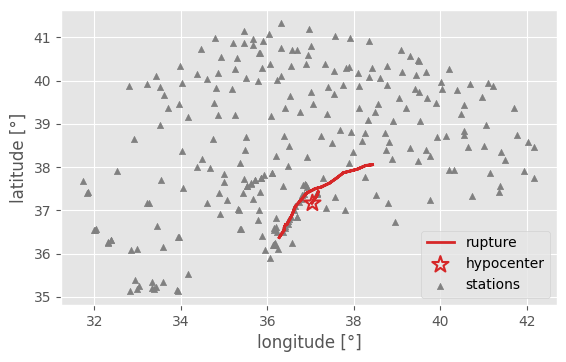

In [4]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
fig, ax = plt.subplots()
for i, surf in enumerate(rupture_surface.surfaces):
    if i == 0: label = 'rupture'
    else: label = None
    ax.plot(surf.mesh.lons, surf.mesh.lats, color='tab:red', lw=2,zorder=2, label=label)
ax.scatter(rupture.hypocenter.longitude, rupture.hypocenter.latitude, marker='*', color='none', 
           edgecolor='tab:red', s=150, zorder=2, label='hypocenter', lw=1.5)
ax.scatter(dfstations['longitude'], dfstations['latitude'], marker='^', s=20, color='gray', alpha=1, zorder=1,label='stations')
ax.set_aspect('equal')
ax.set_xlabel('longitude [°]')
ax.set_ylabel('latitude [°]')
ax.legend()

### Initialize modules

In [ ]:
from modules.shakemap import Stations, GMM
from modules.spatialcorrelation import (HeresiMiranda2019, EspositoIervolino2012esm)
from openquake.hazardlib.gsim.akkar_2014 import AkkarEtAlRjb2014
from openquake.hazardlib.gsim.cauzzi_2014 import CauzziEtAl2014

# Specify considered intensity measure: 'PGA', 'SA(0.3)', 'SA(1.0)', 'SA(3.0)'
im_string = 'SA(1.0)'

# Specify Ground-Motion model
# gmm = GMM(CauzziEtAl2014(), im_string)
gmm = GMM(AkkarEtAlRjb2014(), im_string)

# Specify Correlation model
# scm = EspositoIervolino2012esm(im_string)
scm = HeresiMiranda2019(im_string)

# Wrap stations
stations = Stations(dfstations, ['longitude', 'latitude', 'vs30'], im_string)

Assemble shakemap module

In [ ]:
from modules.shakemap import Shakemap
shakemap = Shakemap(Rupture = rupture, 
                    Stations = stations,
                    GMM = gmm,
                    SpatialCorrelationModel = scm)

### Example 1: Maps of marginal parameters



In [85]:
dfsites = pd.read_csv(path_data + 'grid_example.csv')
bbox = [dfsites.longitude.max(), dfsites.longitude.min(), dfsites.latitude.max(), dfsites.latitude.min()]
lons_bbox = [bbox[0], bbox[0], bbox[1], bbox[1], bbox[0]]
lats_bbox = [bbox[2], bbox[3], bbox[3], bbox[2], bbox[2]]
print('Number of grid points: ' + str(len(dfsites)))

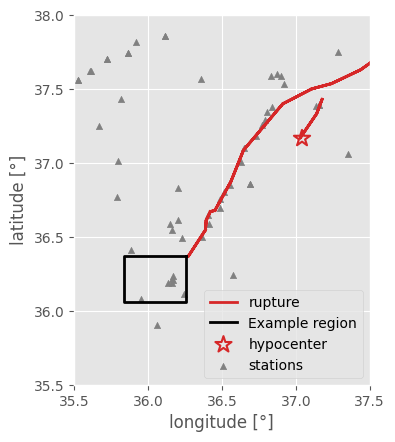

In [86]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
fig, ax = plt.subplots()
for i, surf in enumerate(rupture_surface.surfaces):
    if i == 0: label = 'rupture'
    else: label = None
    ax.plot(surf.mesh.lons, surf.mesh.lats, color='tab:red', lw=2,zorder=2, label=label)
ax.scatter(rupture.hypocenter.longitude, rupture.hypocenter.latitude, marker='*', color='none', 
           edgecolor='tab:red', s=150, zorder=2, label='hypocenter', lw=1.5)
ax.scatter(dfstations['longitude'], dfstations['latitude'], marker='^', s=20, color='gray', alpha=1, zorder=1,label='stations')
ax.plot(lons_bbox, lats_bbox, color='black', lw=2, label='Example region')
# ax.plot(lons_bbox2, lats_bbox2, color='black', lw=0.8, label='Example region 2')
ax.set_xlim([35.5, 37.5]); ax.set_ylim([35.5, 38])
ax.set_aspect('equal')
ax.set_xlabel('longitude [°]')
ax.set_ylabel('latitude [°]')
ax.legend()
plt.show()

#### Compute marginal shakemap parameters

First initialize a `sites` object using the corresponding dataframe. This object initializes an `openquake` mesh, which is used for distance computations. 
Then, use the `predict_logIM` function to compute the mean and variance of logarithmic im values. For input `conditional = True` it computes the parameters conditional on the recorded amplitudes, otherwise it computes the mean and variance of the GMM. For input `full_cov = False`, it computes only the diagonal of the covariance matrix, otherwise it computes the full covariance matrix.

Note that we consider more than 30'000 sites in this example, and with a full computation of the covariance matrix we would most probably run into memory issues. The full computation and sampling procedure is shown in Example 2 for a smaller number of sites.

In [89]:
from modules.shakemap import Sites
sites = Sites(dfsites, ['longitude', 'latitude', 'vs30'])

mu, var = shakemap.predict_logIM(sites, conditional=True, full_cov=False)

Map of median intensity measure value conditional on all recorded amplitudes.

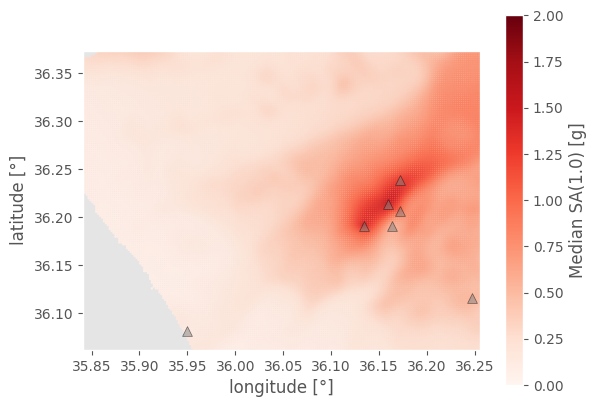

In [92]:
fig, ax = plt.subplots()
im = ax.scatter(dfsites.longitude, dfsites.latitude, c=np.exp(mu2), vmin=0, vmax=2, s=msize, cmap=plt.get_cmap('Reds'))
ax.set_aspect('equal')
for surf in rupture_surface.surfaces:
    ax.plot(surf.mesh.lons, surf.mesh.lats, color='black')
ax.scatter(dfstations['longitude'], dfstations['latitude'], marker='^', s=50, color='gray', alpha=0.5, edgecolor='black')
ax.set_xlim([bbox[1], bbox[0]]); ax.set_ylim([bbox[3], bbox[2]])
ax.grid(False)
plt.colorbar(im, label='Median ' + im_string + ' [g]')
ax.set_xlabel('longitude [°]'); ax.set_ylabel('latitude [°]')
plt.show()

Map of logarithmic standard deviation conditional on all recorded amplitudes.

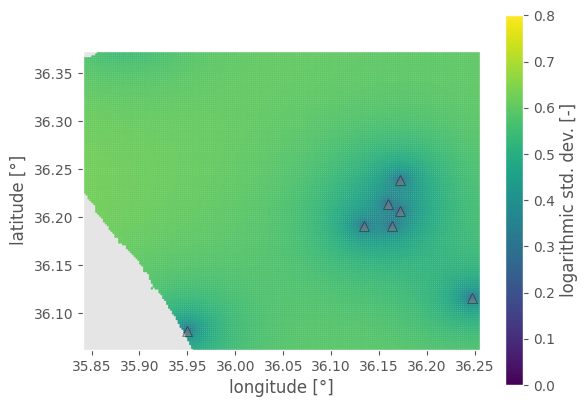

In [93]:
fig, ax = plt.subplots()
im = ax.scatter(dfsites.longitude, dfsites.latitude, c=np.sqrt(var2), vmin=0, vmax=0.8, s=msize, cmap=plt.get_cmap('viridis'))
ax.set_aspect('equal')
for surf in rupture_surface.surfaces:
    ax.plot(surf.mesh.lons, surf.mesh.lats, color='black')
ax.scatter(dfstations['longitude'], dfstations['latitude'], marker='^', s=50, color='gray', alpha=0.5, edgecolor='black')
ax.set_xlim([bbox[1], bbox[0]]); ax.set_ylim([bbox[3], bbox[2]])
ax.grid(False)
plt.colorbar(im, label='logarithmic std. dev. [-]')
ax.set_xlabel('longitude [°]'); ax.set_ylabel('latitude [°]')
plt.show()

### Example 2: Simulate correlated ground-motion amplitudes conditional on recordings

The csv file `buildings_example.csv` contains the location of more than 14000 buildings in the region of Hatay, Turkey (small black dots in the figure below).
For this illustration we randomly sample 2000 buildings from this dataset (orange dots in the figure below).

TODO: Include the size in km of the shown maps!!

In [102]:
del mu, var # gain memory

dfsites = pd.read_csv(path_data + 'buildings_example.csv')
bbox = [dfsites.longitude.max(), dfsites.longitude.min(), dfsites.latitude.max(), dfsites.latitude.min()]
dfsites_sim = dfsites.sample(n=2000, random_state=91)
lons_bbox = [bbox[0], bbox[0], bbox[1], bbox[1], bbox[0]]
lats_bbox = [bbox[2], bbox[3], bbox[3], bbox[2], bbox[2]]

NameError: name 'mu' is not defined

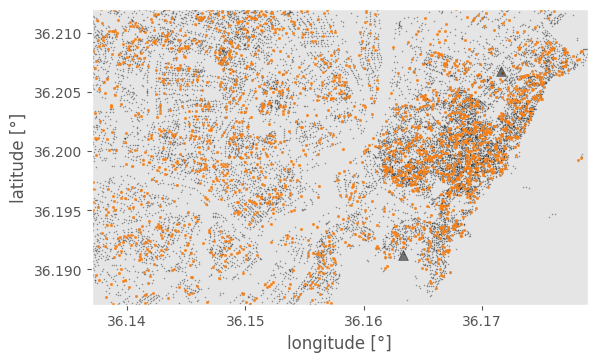

In [95]:
fig, ax = plt.subplots()
im = ax.scatter(dfsites.longitude, dfsites.latitude, color='black', s=0.5, alpha=0.25)
im = ax.scatter(dfsites_sim.longitude, dfsites_sim.latitude, color='tab:orange', s=3, alpha=0.75)
ax.set_aspect('equal')
for surf in rupture_surface.surfaces:
    ax.plot(surf.mesh.lons, surf.mesh.lats, color='black')
ax.scatter(dfstations['longitude'], dfstations['latitude'], marker='^', s=50, color='black', alpha=0.5, edgecolor='black')
ax.set_xlim([bbox[1], bbox[0]]); ax.set_ylim([bbox[3], bbox[2]])
ax.grid(False)
# plt.colorbar(im, label='logarithmic std. dev. [-]')
ax.set_xlabel('longitude [°]'); ax.set_ylabel('latitude [°]')
ax.set_xticks(np.arange(36.140, 36.180, 0.01))
plt.show()

**Visual comparison of two simulated fields**

In [96]:
sites = Sites(dfsites_sim, ['longitude', 'latitude', 'vs30'])
sim_logim2 = shakemap.sample_logIM(sites, nsamples=2, conditional=True, seed=20)

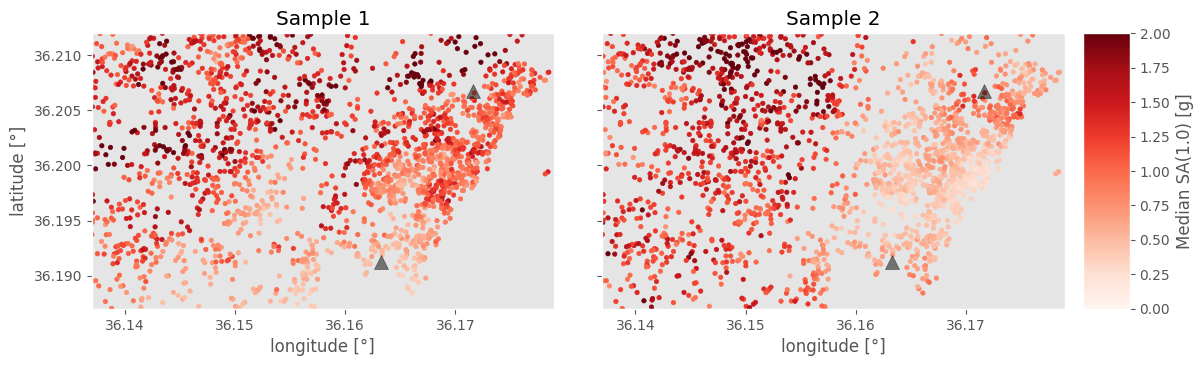

In [97]:
fig, axs = plt.subplots(1,2, figsize=(12,3.5), sharey=True, constrained_layout=True)
for i, ax in enumerate(axs):
    im = ax.scatter(dfsites_sim.longitude, dfsites_sim.latitude, c=np.exp(sim_logim2)[i,:], vmin=0, vmax=2, 
                    s=10, cmap=plt.get_cmap('Reds'))
    ax.set_aspect('equal')
    for surf in rupture_surface.surfaces:
        ax.plot(surf.mesh.lons, surf.mesh.lats, color='black')
    ax.scatter(dfstations['longitude'], dfstations['latitude'], marker='^', s=100, color='black', alpha=0.5, edgecolor='black')
    ax.set_xlim([bbox[1], bbox[0]]); ax.set_ylim([bbox[3], bbox[2]])
    ax.grid(False)
    if i==1: plt.colorbar(im, label='Median ' + im_string + ' [g]')
    if i==0: ax.set_ylabel('latitude [°]')
    ax.set_xlabel('longitude [°]'); 
    ax.set_xticks(np.arange(36.140, 36.180, 0.01))
    ax.set_title('Sample ' + str(i+1))
plt.show()

**Compute proportions of sites where a threshold amplitude was exceeded**

Highlight the variation, despite having a small area with two stations!

In [98]:
nsamples = 10000
threshold = 0.75 # unit g !
sim_logim2 = shakemap.sample_logIM(sites, nsamples=nsamples, conditional=True, seed=31)
prop_exceedance = np.sum((np.exp(sim_logim2) > threshold), axis=1) / len(dfsites_sim)

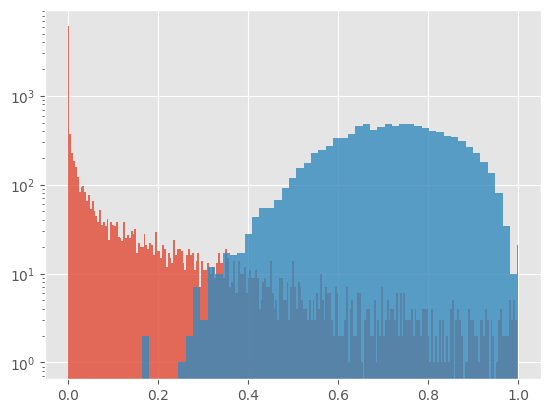

In [101]:
fig, ax = plt.subplots()
ax.hist(prop_exceedance,'auto',alpha=0.8)
ax.set_ylabel('Number of samples')
ax.set_xlabel('Proportion of sites')
plt.show()

In [ ]:
# Probability that threshold was exceeded at 75% of the sites
np.sum(prop_exceedance > 0.75) / nsamples